## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [3]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = [t.translate(str.maketrans('', '', string.punctuation)).lstrip().lower() for t in text if len(t) > 15]
out = "".join(text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
out = set(out)
out.add("<pad>")
tokens = sorted(list(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
idx_to_token = dict((i, token) for i, token in enumerate(tokens))
# dict <char>:<index>
token_to_idx = dict((token, i) for i, token in idx_to_token.items())

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [9]:
from collections.abc import Iterable
import numpy.typing as npt
import numpy as np
import torch

In [39]:
def word_tokens(tokens: Iterable) -> npt.ArrayLike:
    return np.array([token_to_idx[token] for token in tokens])

def sentence_tokens(batch: list) -> npt.ArrayLike:
    return np.concatenate(list(map(word_tokens, batch)))


def shape_text(text: list[str], max_tokens_len: int):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

def get_matrix(text: list[str],  input_len=None, token_to_idx=token_to_idx, pad='<pad>', batch_first=True):
    max_input_len = input_len or max(map(len, text)) 
    output = np.zeros([len(text), max_input_len], 'int64') + token_to_idx[pad]
    
    for idx in range(len(text)):
        line = sentence_tokens([text[idx]])
        output[idx, :len(line)] = line
    if  not batch_first:
        output = output.T
    return torch.tensor(output)

### Building the model

In [40]:
from torch import nn
import torch.nn.functional as F

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [41]:
class VanillaCharRNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)

In [42]:
from collections.abc import Callable

In [66]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
def fit_epoch(model: nn.Module, hidden_state: Iterable, tepoch: Iterable, everything: Iterable, batch_size: int, n_batches: int=16, ltsm: bool=False):
    loss = nn.CrossEntropyLoss(ignore_index=token_to_idx['<pad>'])
    running_loss = 0.0
    for i in tepoch:
        batch = everything[i:i+batch_size]
        hidden_state, out = model(batch, hidden_state)
        next_tokens = batch[:, 1:]

        loss_ = loss(out[:, :-1].reshape(-1, len(tokens)), next_tokens.reshape(-1))
        loss_.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss_.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

    running_loss /= n_batches
    return hidden_state, running_loss


def train_model(model: nn.Module, text: Iterable, optimizer: Callable, n_epochs: int=50, batch_size: int=16):

    losses = []
    shaped = shape_text(text, 60)

    everything = get_matrix(shaped, 60)

    state = model.initial_state(batch_size)

    n_batches = everything.shape[0] // batch_size

    for epoch in range(n_epochs):
        with tqdm(range(0, n_batches * batch_size, batch_size)) as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            state, epoch_loss = fit_epoch(model, state, tepoch, everything, batch_size, n_batches)
            losses.append(epoch_loss)
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss")
        plt.show()
    return losses, state

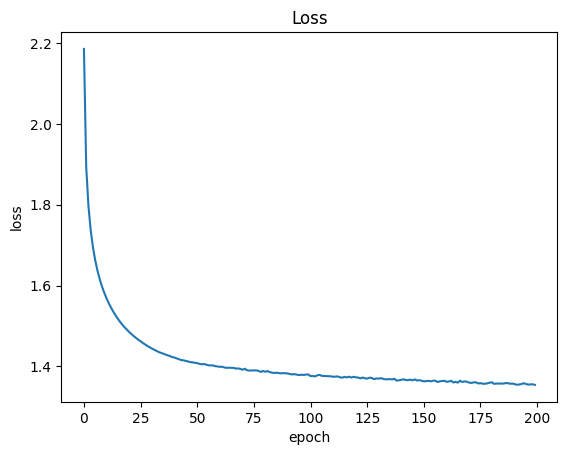

In [71]:
model = VanillaCharRNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, betas=[0.5, 0.5])
vanilla_losses, vanilla_state = train_model(model, text, optimizer, n_epochs=200)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [83]:
def generate_sample(model, seed_phrase='pay', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [84]:
# An example of generated text.
print(generate_sample(model, temperature=0.2))

pay the prove
 the proud that thou art thou art thou fair that thou fair thou feeds to the proud that thou art that thou love to my sake
 thou be thou thy self thy constance and thou art thou forget thou fair the present is thy love thou fair thou wilt thou art thou fair the present make the sun no present is thy sweet he worse beauty is not more that thou be thou mayst for my hate
 the love and t


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [87]:
class LSTMCharRNN(nn.Module):

    def __init__(self, num_tokens: int=len(tokens), embedding_size: int=64, rnn_num_units: int=128):
        super(LSTMCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size, padding_idx=token_to_idx['<pad>'])
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states=None):
        x_emb = self.embedding(x)
        if states is None:
            states = self.initial_state(1)
        out, states = self.lstm(x_emb, states)
        
        logits = self.linear(out)
        return states, logits
    
    def initial_state(self, batch_size):
        return (
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        )

In [89]:
def fit_epoch_LSTM(model: nn.Module, states: Iterable, tepoch: Iterable, everything: Iterable, batch_size: int, n_batches: int=16, ltsm: bool=False):
    loss = nn.CrossEntropyLoss(ignore_index=token_to_idx['<pad>'])
    running_loss = 0.0
    for i in tepoch:
        batch = everything[i:i+batch_size]
        states, out = model(batch, states)
        hidden_state, cell_state = states

        next_tokens = batch[:, 1:]

        loss_ = loss(out[:, :-1].reshape(-1, len(tokens)), next_tokens.reshape(-1))
        loss_.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss_.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

        cell_state.detach_()
        cell_state = cell_state.detach()

        states = hidden_state, cell_state

    running_loss /= n_batches
    return states, running_loss


def train_model_LSTM(model: nn.Module, text: Iterable, optimizer: Callable, n_epochs: int=50, batch_size: int=16):

    losses = []
    shaped = shape_text(text, 60)

    everything = get_matrix(shaped, 60)

    state = model.initial_state(batch_size)

    n_batches = everything.shape[0] // batch_size

    for epoch in range(n_epochs):
        with tqdm(range(0, n_batches * batch_size, batch_size)) as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            state, epoch_loss = fit_epoch_LSTM(model, state, tepoch, everything, batch_size, n_batches)
            losses.append(epoch_loss)
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss")
        plt.show()
    return losses, state

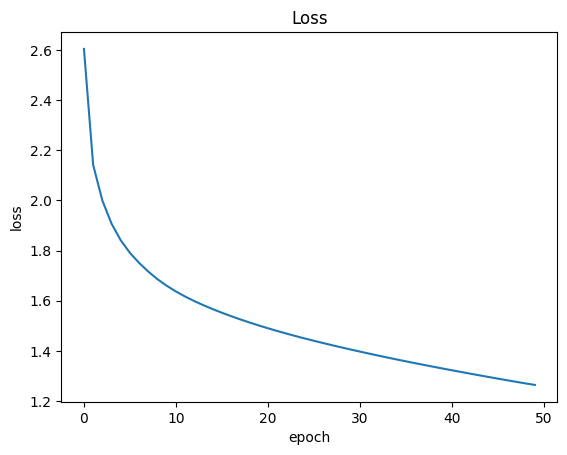

In [91]:
model = LSTMCharRNN()
optimizer = torch.optim.Adam(model.parameters())
lstm_losses, lstm_state = train_model_LSTM(model, text, optimizer, n_epochs=50)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [95]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    display.display(display.Markdown(f"### Temperature {t}"))
    print(generate_sample(model, temperature=t))

### Temperature 0.1

pay
 the world will the state
 the state the world with thee as thou the state
 which hath the state the world with thy self all the state
 which hate the world with thy strungest thou thy beauty seem thee
 the beauty so thee as thou art thee heart thou art thee as thou art to thee her fair i will be their rand so i love thee hath my heart to thee
 the beauty so love the state
 then beauty so thee


### Temperature 0.2

pay
 so it the thought is my love thee heart thou art to thee
 the wark is thy self the thing my heart to my heart to thee
 and there is the rest in the world well shall i see thee
 when i say the world will be their state
 when i have stand the state of thee
 and they see the time to my love the strength and thee
 and there that i have state the state
 then thou thy self the think the world with 


### Temperature 0.5

pay
 so it is to the rest and look a found with most thou there
 that i being so and they and her words and best
 i am so then their sard soul not to me which can stell
 as thou art and the time not the world make
 then of thy to still the state
 when i say on the will with lack
 the still the world i writ her beauty so thee
 which my love that thou my soul
 and they thee hear the wretching and we


### Temperature 1.0

pay
 the juest his guiltion wretest find in loverps are not
 again
 had must the death how lovd
 give as thr lies worst of thee as youth to have straight this mare
 it do your plighin left to my heart
 hath not with tus ne of wrich hare
 and in thee as my tis praises bessy
 me or thy speak and so thus and and love
 she must without the ceem
 nor thou grow to like and as under tends
 thine eyes me 


### Temperature 2.0

pay
 notrraokel
 dfori swandisonsweppiest ow tesbosd
 to m dnto myce ezvery liajes suw pyers out or windat
 as tuts ruth boillate wrinjlumd
 contrravudgg againwildap wild besafrucky hce
 not leakewmickbeluspmotny to needsts inhy
 thichous domflibstect beeds
 an wetifrlnufth the carfedilige crsar sconitlink oed antails this ecquivicippqixthixt paly wreffed
lusinfulel withlindses lepjsep even
 mirty


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [96]:
torch.save(model.state_dict(), "lstm_model.hd5")
del model

In [97]:
model = LSTMCharRNN()
model.load_state_dict(torch.load('lstm_model.hd5'))
model.eval()

LSTMCharRNN(
  (embedding): Embedding(29, 64, padding_idx=2)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=29, bias=True)
)

In [98]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    display.display(display.Markdown(f"### Temperature {t}"))
    print(generate_sample(model, temperature=t))

### Temperature 0.1

pay
 so the world with the thin thy heart to thee
 the world with the time to me to thee
 the world will the state the world with thee
 then beauty so thee as thou thy strent so the state
 then thou thy self the think thou art to thee
 the world will the state the world with thee as thou the state
 then thou thy self the think the world with thee
 when i see thee the world with thy state
 then bea


### Temperature 0.2

pay
 the fair shall be thou the state
 then beauty so love they see thee hear thee
 that i have soul the world with thy sweet seem woe
 the state the state thy self all the world well or thee
 that i have state
 and therefore the thing me thou art to thee
 the world will the state of heart
 and there is not thy fair shall i love they see thee
 that i have no me the recounted to thee
 the world wit


### Temperature 0.5

pay
 the poor soulling thy deeds
 the rarth in my love to me i the hand
 and the thin thy heart to my self so deeds
 the present is thy seem now and all the fair
 make thee the wrance and they see my heart to my heart
 whilst i disprace
 which more that this should that which doth me as he in thine eyes
 for the subject which i my heart to me
 thou art that we worth the sun is this to thy percious


### Temperature 1.0

pay
 so fair humpblight gaate
 till mee boot aften true in black dead
 hold that he their black
 for which should with a least i past that elis
 kink fe in the eyet which keen
 when i justill hath their own
 but up doot thy will
 the calls of their windst thou dost posiek depalacded her pleard
 and not papiy black and byet lies
 o tame and her to my lubtern so the which thou hose
 my lines outward


### Temperature 2.0

paye
 wrint deecdod fresh who
 ums ibubqagenacd
 to remebletievourmblyfril
 anivityho atiod
 tided but ingrixwderiptivd abidned
 that dialove raimaslen say phhbwany lowdlon
 imy ap itsiugesy assawom
 thisd imphishming night
 ifty teembaciae ck by prided hod
 nekeasacenooy it had wing
 and byind whereformime o ten
 forted n towwouls knormyst ervairing vensequious elf lyfect
 whentews nomecomls voud


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)